In [29]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [10]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for category in os.listdir(folder):
        for filename in os.listdir(os.path.join(folder,category)):
            img = cv2.imread(os.path.join(folder,category,filename))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert from BGR to RGB
                images.append(img)
                labels.append(category)
    return np.array(images), np.array(labels)


In [12]:
train_folder = 'D:/10th Semester/CIFAR-10/train'
test_folder = 'D:/10th Semester/CIFAR-10/test'
train_images, train_labels = load_images_from_folder(train_folder)
test_images, test_labels = load_images_from_folder(test_folder)


In [13]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [14]:
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Training images shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


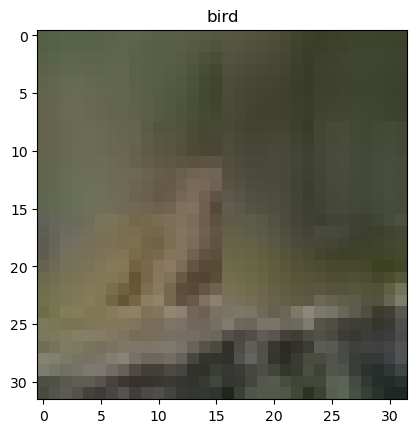

In [6]:
import matplotlib.pyplot as plt

# select an image to view
image_index = 10090

# display the image
plt.imshow(train_images[image_index])
plt.title(train_labels[image_index])
plt.show()

In [40]:
import numpy as np

# set the number of samples to use for subsampling
num_training = 5000
num_testing = 500

# randomly select indices for subsampling
train_indices = np.random.choice(len(train_images), num_training , replace=False)
test_indices = np.random.choice(len(test_images), num_testing, replace=False)

# subsample the training and test data using the selected indices
train_images_sub = train_images[train_indices]
train_labels_sub = train_labels[train_indices]
X_train = train_images_sub
y_train = train_labels_sub

test_images_sub = test_images[test_indices]
test_labels_sub = test_labels[test_indices]

X_test = test_images_sub
y_test = test_labels_sub


In [41]:
# get the dimensions of the images
image_dim = train_images.shape[1:]

# flatten the images into 1D arrays
train_images_flat = train_images_sub.reshape(train_images_sub.shape[0], -1)
test_images_flat = test_images_sub.reshape(test_images_sub.shape[0], -1)

# print the new shapes of the flattened arrays
print("Training images shape (flat):", train_images_flat.shape)
print("Test images shape (flat):", test_images_flat.shape)


Training images shape (flat): (5000, 3072)
Test images shape (flat): (500, 3072)


In [32]:
class KNearestNeighbor(object):

  def __init__(self):
    pass

  def train(self, X, y):
    self.X_train = X
    self.y_train = y
    
  def predict(self, X, k=1, num_loops=0):
    if num_loops == 0:
      dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)
    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
        for j in range(num_train):
            dists[i, j] = np.sqrt(np.sum((X[i, :] - self.X_train[j, :]) **2))
    return dists

  def compute_distances_one_loop(self, X):
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      dists[i, :] = np.sqrt(np.sum((self.X_train - X[i, :])**2, axis=1))
    return dists

  def compute_distances_no_loops(self, X):
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train)) 
    dists = np.sqrt((-2 * np.dot(X, self.X_train.T)) + np.sum(X**2, axis=1, keepdims=True) + np.sum(self.X_train**2, axis=1))
    return dists

  def compute_l1_distances_two_loops(self, X):
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
        for j in range(num_train):
            dists[i, j] = np.sum((X[i, :] - self.X_train[j, :]))
    return dists

  def predict_labels(self, dists, k=1):
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test, dtype=self.y_train.dtype)
    for i in range(num_test):
        k_nearest_idxs = np.argsort(dists[i, :])[:k]
        closest_y = self.y_train[k_nearest_idxs]
        label_count = {}
        for label in closest_y:
            if label in label_count:
                label_count[label] += 1
            else:
                label_count[label] = 1
        y_pred[i] = max(label_count, key=label_count.get)
    return y_pred


In [25]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [26]:
dists = classifier.compute_distances_two_loops(X_test)
print( dists.shape)

(50, 500)


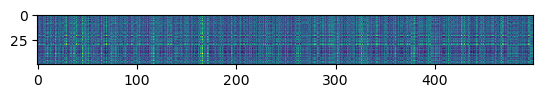

In [30]:
plt.imshow(dists, interpolation='none')
plt.show()

In [42]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

import random

random_list = random.sample(list(zip(X_train, y_train)), len(list(zip(X_train, y_train))))
X_train, y_train = zip(*random_list)

X_train_folds = np.array_split(X_train, num_folds, axis=0) # list
y_train_folds = np.array_split(y_train, num_folds, axis=0) # list

k_to_accuracies = {}

for i in range(num_folds):
    X_train_batch = np.concatenate(X_train_folds[1:num_folds])   
    y_train_batch = np.concatenate(y_train_folds[0:num_folds])
    
    X_valid_batch = X_train_folds[0]   
    y_valid_batch = y_train_folds[0]
    
    if i < num_folds - 1:
        tmp = X_train_folds[0]
        X_train_folds[0] = X_train_folds[i+1]
        X_train_folds[i+1] = tmp
        tmp = y_train_folds[0]
        y_train_folds[0] = y_train_folds[i+1]
        y_train_folds[i+1] = tmp

    model = KNearestNeighbor()
    model.train(X_train_batch, y_train_batch)
    dists = model.compute_distances_two_loops(X_valid_batch)
    for k in k_choices:
        y_valid_pred = model.predict_labels(dists,k=k)
        num_correct = np.sum(y_valid_pred == y_valid_batch)
        accuracy = float(num_correct) / y_valid_batch.shape[0]
        if i == 0:
            k_to_accuracies[k] = [] 
        k_to_accuracies[k].append(accuracy)

for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        
        print (k, accuracy)

k_to_l1_accuracies = {}


for i in range(num_folds):
    X_train_batch = np.concatenate(X_train_folds[1:num_folds])   
    y_train_batch = np.concatenate(y_train_folds[0:num_folds])
    
    X_valid_batch = X_train_folds[0]   
    y_valid_batch = y_train_folds[0]
    
    if i < num_folds - 1:
        tmp = X_train_folds[0]
        X_train_folds[0] = X_train_folds[i+1]
        X_train_folds[i+1] = tmp
        tmp = y_train_folds[0]
        y_train_folds[0] = y_train_folds[i+1]
        y_train_folds[i+1] = tmp

    model = KNearestNeighbor()
    model.train(X_train_batch, y_train_batch)
    dists = model.compute_l1_distances_two_loops(X_valid_batch)
    for k in k_choices:
        y_valid_pred = model.predict_labels(dists,k=k)
        num_correct = np.sum(y_valid_pred == y_valid_batch)
        accuracy = float(num_correct) / y_valid_batch.shape[0]
        if i == 0:
            k_to_l1_accuracies[k] = [] 
        k_to_l1_accuracies[k].append(accuracy)

for k in sorted(k_to_l1_accuracies):
    for accuracy in k_to_l1_accuracies[k]:
        
        print (k, accuracy)

1 0.106
1 0.108
1 0.099
1 0.082
1 0.107
3 0.1
3 0.103
3 0.101
3 0.082
3 0.107
5 0.098
5 0.113
5 0.116
5 0.085
5 0.103
8 0.108
8 0.105
8 0.114
8 0.09
8 0.101
10 0.118
10 0.113
10 0.119
10 0.094
10 0.099
12 0.114
12 0.107
12 0.105
12 0.102
12 0.097
15 0.095
15 0.109
15 0.113
15 0.094
15 0.112
20 0.117
20 0.121
20 0.123
20 0.085
20 0.106
50 0.11
50 0.097
50 0.124
50 0.094
50 0.12
100 0.101
100 0.107
100 0.122
100 0.093
100 0.104
1 0.114
1 0.103
1 0.093
1 0.092
1 0.11
3 0.114
3 0.103
3 0.093
3 0.092
3 0.1
5 0.114
5 0.103
5 0.093
5 0.092
5 0.11
8 0.114
8 0.086
8 0.093
8 0.092
8 0.11
10 0.114
10 0.086
10 0.093
10 0.092
10 0.096
12 0.114
12 0.093
12 0.093
12 0.092
12 0.096
15 0.114
15 0.093
15 0.093
15 0.092
15 0.096
20 0.114
20 0.093
20 0.102
20 0.092
20 0.087
50 0.114
50 0.103
50 0.111
50 0.103
50 0.096
100 0.105
100 0.1
100 0.111
100 0.103
100 0.096


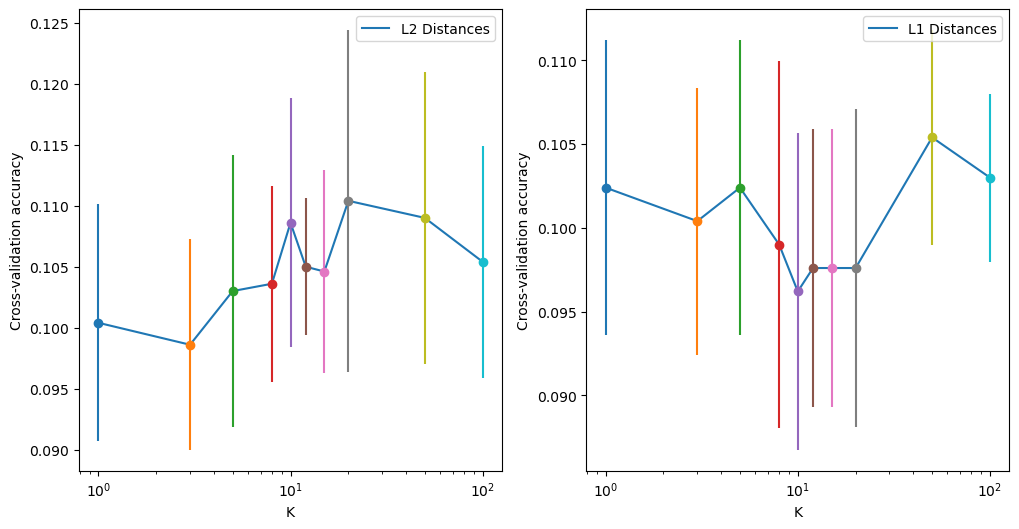

In [44]:
import matplotlib.pyplot as plt

# Plot accuracies for each k value for L2 distances
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for k in k_choices:
    accuracies = k_to_accuracies[k]
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    axs[0].errorbar(k, mean_accuracy, yerr=std_accuracy, fmt='o')
    
# Add trend line
axs[0].plot(k_choices, [np.mean(k_to_accuracies[k]) for k in k_choices], label='L2 Distances')

axs[0].set_xscale('log')
axs[0].set_xlabel('K')
axs[0].set_ylabel('Cross-validation accuracy')
axs[0].legend(loc='best')

# Plot accuracies for each k value for L1 distances
for k in k_choices:
    accuracies = k_to_l1_accuracies[k]
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    axs[1].errorbar(k, mean_accuracy, yerr=std_accuracy, fmt='o')

# Add trend line
axs[1].plot(k_choices, [np.mean(k_to_l1_accuracies[k]) for k in k_choices], label='L1 Distances')

axs[1].set_xscale('log')
axs[1].set_xlabel('K')
axs[1].set_ylabel('Cross-validation accuracy')
axs[1].legend(loc='best')

plt.show()


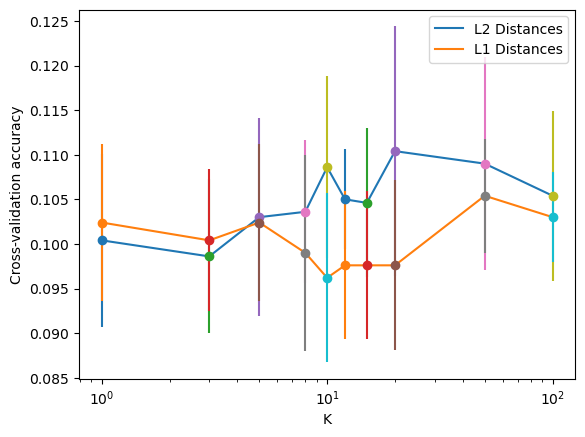

In [43]:
import matplotlib.pyplot as plt

# Plot accuracies for each k value
for k in k_choices:
    accuracies = k_to_accuracies[k]
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    plt.errorbar(k, mean_accuracy, yerr=std_accuracy, fmt='o')
    
    accuracies = k_to_l1_accuracies[k]
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    plt.errorbar(k, mean_accuracy, yerr=std_accuracy, fmt='o')

# Add trend line
plt.plot(k_choices, [np.mean(k_to_accuracies[k]) for k in k_choices], label='L2 Distances')
plt.plot(k_choices, [np.mean(k_to_l1_accuracies[k]) for k in k_choices], label='L1 Distances')

plt.xscale('log')
plt.xlabel('K')
plt.ylabel('Cross-validation accuracy')
plt.legend(loc='best')
plt.show()


As we can see, the accuracy rate of L2 is better than the L1